# Understanding the August 24, 2015 ETF Flash Crash

<a href="https://colab.research.google.com/github/shiong-tan/etf-flash-crash-2015/blob/master/notebooks/01-understanding-the-crash.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook demonstrates the key mechanisms that failed on August 24, 2015, using the educational utilities in this repository.

## ⚠️ Important: Run the Setup Cell First!

**You must run Cell 1 (Setup) before any other cells.** This cell:
- ✅ Detects if you're in Google Colab or local Jupyter
- ✅ Automatically clones the repo (in Colab)
- ✅ Installs dependencies (in Colab)
- ✅ Imports all necessary functions

**In Colab**: Just click "Runtime → Run all" to execute everything in order.

**Locally**: Run cells sequentially from top to bottom.

If you see `NameError: name 'X' is not defined`, it means you skipped the setup cell.

---

## Learning Objectives

1. Understand ETF pricing: NAV vs iNAV
2. See how order book "air pockets" caused extreme slippage
3. Visualize the RSP crash and recovery
4. Understand why arbitrage failed when markets needed it most

---

In [1]:
# ============================================================================
# SETUP - Run this cell first!
# Works in both Google Colab and local Jupyter environments
# ============================================================================

import sys
import os
from pathlib import Path

# Detect environment
try:
    import google.colab
    IN_COLAB = True
    print("🌐 Running in Google Colab")
except ImportError:
    IN_COLAB = False
    print("💻 Running in local Jupyter environment")

# Setup for Colab
if IN_COLAB:
    print("\n📥 Setting up Colab environment...")
    
    # Clone repository if not already present
    if not os.path.exists('/content/etf-flash-crash-2015'):
        print("  Cloning repository...")
        try:
            # Try to clone (will fail for private repos)
            exit_code = os.system('git clone https://github.com/shiong-tan/etf-flash-crash-2015.git /content/etf-flash-crash-2015 2>/dev/null')
            
            if exit_code != 0:
                # Clone failed - likely private repo
                print("\n  ⚠️  This is a private repository!")
                print("\n  To use this notebook in Colab, choose one of these options:")
                print("\n  OPTION 1: Make the repository public")
                print("    1. Go to: https://github.com/shiong-tan/etf-flash-crash-2015/settings")
                print("    2. Scroll to 'Danger Zone'")
                print("    3. Click 'Change visibility' → 'Make public'")
                print("    4. Restart this Colab notebook")
                print("\n  OPTION 2: Use GitHub authentication")
                print("    Run this in a new cell:")
                print("    ```")
                print("    from google.colab import userdata")
                print("    import os")
                print("    # First, add your GitHub token to Colab secrets:")
                print("    # 1. Click 🔑 icon in left sidebar")
                print("    # 2. Add secret: Name='GITHUB_TOKEN', Value='your_github_token'")
                print("    token = userdata.get('GITHUB_TOKEN')")
                print("    !git clone https://{token}@github.com/shiong-tan/etf-flash-crash-2015.git /content/etf-flash-crash-2015")
                print("    ```")
                print("\n  OPTION 3: Download and upload manually")
                print("    1. Download repo as ZIP from GitHub")
                print("    2. Upload to Colab using Files panel (📁 in left sidebar)")
                print("    3. Extract: !unzip etf-flash-crash-2015-master.zip")
                print("    4. Rename: !mv etf-flash-crash-2015-master etf-flash-crash-2015")
                
                raise RuntimeError(
                    "Cannot clone private repository. See options above."
                )
            else:
                print("  ✅ Repository cloned")
        except Exception as e:
            print(f"  ❌ Clone failed: {e}")
            raise
    else:
        print("  ✅ Repository already exists")
    
    # Install dependencies
    print("  Installing dependencies...")
    os.system('pip install -q pandas numpy matplotlib seaborn')
    print("  ✅ Dependencies installed")
    
    # Set working directory and add src to path
    os.chdir('/content/etf-flash-crash-2015')
    src_dir = Path('/content/etf-flash-crash-2015/src')
    data_dir = Path('/content/etf-flash-crash-2015/assets/data')
    
    # Adjust data paths for Colab
    globals()['DATA_PATH_PREFIX'] = 'assets/data/'
    
else:
    # Setup for local Jupyter
    print("\n📂 Setting up local environment...")
    
    notebook_dir = Path().resolve()
    print(f"  Current directory: {notebook_dir}")
    
    # Determine src directory location based on notebook location
    # Case 1: In notebooks/core/ or notebooks/extensions/ → go up 2 levels
    if notebook_dir.parent.name == 'notebooks':
        project_root = notebook_dir.parent.parent
        src_dir = project_root / 'src'
        data_dir = project_root / 'assets' / 'data'
        globals()['DATA_PATH_PREFIX'] = '../../assets/data/'
    # Case 2: In notebooks/ directory → go up 1 level
    elif notebook_dir.name == 'notebooks':
        project_root = notebook_dir.parent
        src_dir = project_root / 'src'
        data_dir = project_root / 'assets' / 'data'
        globals()['DATA_PATH_PREFIX'] = '../assets/data/'
    # Case 3: In project root (has notebooks/ subdirectory) → use directly
    elif (notebook_dir / 'notebooks').exists():
        project_root = notebook_dir
        src_dir = project_root / 'src'
        data_dir = project_root / 'assets' / 'data'
        globals()['DATA_PATH_PREFIX'] = 'assets/data/'
    # Case 4: Fallback - assume we're one level deep
    else:
        project_root = notebook_dir.parent
        src_dir = project_root / 'src'
        data_dir = project_root / 'assets' / 'data'
        globals()['DATA_PATH_PREFIX'] = '../assets/data/'
    
    print(f"  Project root: {project_root}")
    print(f"  Looking for src at: {src_dir}")
    print(f"  src exists: {src_dir.exists()}")
    
    if not src_dir.exists():
        raise FileNotFoundError(
            f"Cannot find src directory at: {src_dir}\n"
            f"Current directory: {notebook_dir}\n"
            f"Expected project structure:\n"
            f"  project_root/\n"
            f"    ├── src/\n"
            f"    ├── notebooks/\n"
            f"    │   ├── core/\n"
            f"    │   └── extensions/\n"
            f"    └── assets/\n"
        )

# Add src to Python path
sys.path.insert(0, str(src_dir))
print(f"  ✅ Added to path: {src_dir}")

# Import standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Import custom modules with error handling
print("\n📦 Importing ETF flash crash modules...")

try:
    from etf_pricing import (
        calculate_nav, calculate_inav, arbitrage_spread,
        creation_profit, simulate_stale_inav
    )
    print("  ✅ etf_pricing")
except ImportError as e:
    print(f"  ❌ etf_pricing: {e}")
    raise

try:
    from order_book import OrderBook, simulate_stop_loss_cascade
    print("  ✅ order_book")
except ImportError as e:
    print(f"  ❌ order_book: {e}")
    raise

try:
    from visualization import (
        plot_price_vs_inav, plot_order_book, plot_luld_bands,
        plot_stop_loss_cascade
    )
    print("  ✅ visualization")
except ImportError as e:
    print(f"  ⚠️  visualization: {e}")
    print("     (Optional - install matplotlib if you want visualizations)")

# Configure matplotlib
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except OSError:
    try:
        plt.style.use('seaborn-darkgrid')
    except OSError:
        print("  ℹ️  Using default matplotlib style")

# Enable inline plotting
if IN_COLAB:
    from IPython.display import set_matplotlib_formats
    set_matplotlib_formats('retina')
else:
    try:
        get_ipython().run_line_magic('matplotlib', 'inline')
    except:
        pass

print("\n" + "="*60)
print("✅ SETUP COMPLETE - Ready to explore the flash crash!")
print("="*60)
print(f"\n📊 Data directory: {data_dir}")
print(f"🐍 Python modules loaded from: {src_dir}")

if IN_COLAB:
    print("\n💡 Tip: You can edit and run cells. Changes won't affect the GitHub repo.")
else:
    print("\n💡 Tip: Run cells in order from top to bottom.")

💻 Running in local Jupyter environment

📂 Setting up local environment...
  Current directory: /Users/shiongtan/projects/etf-flash-crash-2015/notebooks/core
  Project root: /Users/shiongtan/projects/etf-flash-crash-2015
  Looking for src at: /Users/shiongtan/projects/etf-flash-crash-2015/src
  src exists: True
  ✅ Added to path: /Users/shiongtan/projects/etf-flash-crash-2015/src



📦 Importing ETF flash crash modules...
  ✅ etf_pricing
  ✅ order_book
  ✅ visualization

✅ SETUP COMPLETE - Ready to explore the flash crash!

📊 Data directory: /Users/shiongtan/projects/etf-flash-crash-2015/assets/data
🐍 Python modules loaded from: /Users/shiongtan/projects/etf-flash-crash-2015/src

💡 Tip: Run cells in order from top to bottom.


## Part 1: ETF Pricing Fundamentals

### Normal Conditions: NAV and iNAV

In normal markets, an ETF's price stays close to its Net Asset Value (NAV):

- **NAV**: Calculated once daily at 4 PM using closing prices
- **iNAV**: Calculated every 15 seconds during trading hours using current prices

Let's calculate these for a simple ETF:

In [2]:
# Example: Simple 3-stock ETF
holdings = {
    'AAPL': 100,
    'MSFT': 150,
    'GOOGL': 50
}

# Closing prices (4 PM)
closing_prices = {
    'AAPL': 112.50,
    'MSFT': 44.80,
    'GOOGL': 648.20
}

# Current prices (during trading)
current_prices = {
    'AAPL': 110.25,  # Down $2.25
    'MSFT': 44.00,   # Down $0.80
    'GOOGL': 642.50  # Down $5.70
}

shares_outstanding = 1_000_000

# Calculate NAV (using closing prices)
nav = calculate_nav(holdings, closing_prices, shares_outstanding)
print(f"NAV (4 PM close): ${nav:.2f}")

# Calculate iNAV (using current prices)
inav = calculate_inav(holdings, current_prices, shares_outstanding)
print(f"iNAV (current): ${inav:.2f}")
print(f"Difference: ${inav - nav:.2f} ({(inav - nav) / nav * 100:.2f}%)")

NAV (4 PM close): $0.05
iNAV (current): $0.05
Difference: $-0.00 (-1.25%)


### Arbitrage Keeps Prices Aligned

When ETF price diverges from iNAV, arbitrageurs profit by:
- **Creation**: Buy underlying stocks, create ETF shares, sell ETF (when ETF > iNAV)
- **Redemption**: Buy ETF, redeem for stocks, sell stocks (when ETF < iNAV)

Let's see this in action:

In [3]:
# Check if setup was run
try:
    arbitrage_spread
except NameError:
    raise RuntimeError(
        "⚠️ Setup cell not run!\n\n"
        "Please scroll to the top and run Cell 1 (Setup) first:\n"
        "- Click on Cell 1\n"
        "- Press Shift+Enter\n"
        "- Wait for '✅ Setup complete'\n"
        "- Then come back here\n\n"
        "OR use menu: Kernel → Restart & Run All"
    )

# ETF trading at premium
etf_price_premium = 50.15
fair_value_per_share = 50.00
creation_unit_size = 50_000

# Calculate spread (returns dict)
spread_result = arbitrage_spread(etf_price_premium, fair_value_per_share)
spread_pct = spread_result['spread_pct']
spread_bps = spread_result['spread_bps']

# Calculate creation profit (returns dict)
basket_value = fair_value_per_share * creation_unit_size
profit_result = creation_profit(
    etf_price=etf_price_premium,
    basket_value=basket_value,
    creation_unit_size=creation_unit_size,
    transaction_costs_bps=25.0
)
profit_per_share = profit_result['net_profit'] / creation_unit_size

print(f"ETF Price: ${etf_price_premium:.2f}")
print(f"Fair Value (iNAV): ${fair_value_per_share:.2f}")
print(f"Spread: {spread_pct:.2f}% ({spread_bps:.0f} bps)")
print(f"\nArbitrage Opportunity: CREATION")
print(f"Profit per share: ${profit_per_share:.4f}")
print(f"Profit per creation unit ({creation_unit_size:,} shares): ${profit_result['net_profit']:,.2f}")

# ETF trading at discount
etf_price_discount = 49.85
print(f"\n{'='*50}")
print(f"ETF Price: ${etf_price_discount:.2f}")
print(f"Fair Value (iNAV): ${fair_value_per_share:.2f}")
spread_result = arbitrage_spread(etf_price_discount, fair_value_per_share)
print(f"Spread: {spread_result['spread_pct']:.2f}% ({spread_result['spread_bps']:.0f} bps)")
print(f"\nArbitrage Opportunity: REDEMPTION")
print("(Buy ETF cheap, redeem for stocks, sell stocks)")

ETF Price: $50.15
Fair Value (iNAV): $50.00
Spread: 0.30% (30 bps)

Arbitrage Opportunity: CREATION
Profit per share: $0.0250
Profit per creation unit (50,000 shares): $1,250.00

ETF Price: $49.85
Fair Value (iNAV): $50.00
Spread: -0.30% (-30 bps)

Arbitrage Opportunity: REDEMPTION
(Buy ETF cheap, redeem for stocks, sell stocks)


## Part 2: What Broke on August 24, 2015

### The Stale iNAV Problem

When underlying stocks are halted, their prices become stale, but iNAV calculations still use them.
This creates a **fake arbitrage signal**.

In [4]:
# Check if setup was run
try:
    simulate_stale_inav
except NameError:
    raise RuntimeError(
        "⚠️ Setup cell not run!\n\n"
        "Please go back to Cell 1 (Setup) and run it first by:\n"
        "1. Click on Cell 1\n"
        "2. Press Shift+Enter\n"
        "3. Wait for '✅ Setup complete' message\n"
        "4. Then come back and run this cell\n\n"
        "OR use: Kernel → Restart & Run All"
    )

# Simulate RSP-like situation
# 500 stocks, 20% halted at old (higher) prices, 80% down 4%

# Create synthetic holdings (equal weight like RSP)
num_stocks = 500
holdings = {f'STOCK_{i}': 1 for i in range(num_stocks)}

# Stale prices (previous close)
stale_prices = {f'STOCK_{i}': 100.0 for i in range(num_stocks)}

# 20% of stocks halted (still at old prices)
num_halted = int(num_stocks * 0.20)
halted_tickers = [f'STOCK_{i}' for i in range(num_halted)]

# Current prices: halted stocks use stale prices, others down 4%
current_prices = {
    ticker: stale_prices[ticker] if ticker in halted_tickers else stale_prices[ticker] * 0.96
    for ticker in holdings.keys()
}

# Calculate stale vs true iNAV
result = simulate_stale_inav(
    holdings=holdings,
    current_prices=current_prices,
    stale_prices=stale_prices,
    halted_tickers=halted_tickers,
    creation_unit_size=500  # shares_outstanding in creation units
)

print("AUGUST 24, 2015 SCENARIO")
print("="*50)
print(f"ETF: RSP (S&P 500 Equal Weight)")
print(f"Underlying stocks halted: {result['pct_halted']:.0f}%")
print(f"\nActual market decline: 4.0%")
print(f"\nCalculated iNAV: ${result['inav_with_stale']:.2f}")
print(f"True fair value: ${result['inav_true']:.2f}")
print(f"iNAV error: ${result['inav_with_stale'] - result['inav_true']:.2f}")
print(f"\n⚠️ iNAV overstates value by {result['error_pct']:.1f}%")
print("\nMarket maker sees:")
print(f"  - ETF trading at $50")
print(f"  - iNAV showing ${result['inav_with_stale']:.2f}")
print(f"  - Apparent discount: {((50 - result['inav_with_stale']) / result['inav_with_stale'] * 100):.1f}%")
print("\n❌ But can't arbitrage:")
print("  - Can't buy halted stocks to hedge")
print("  - Can't short halted stocks")
print("  - iNAV is based on stale data")
print("\n💡 Result: Market makers step away")

AUGUST 24, 2015 SCENARIO
ETF: RSP (S&P 500 Equal Weight)
Underlying stocks halted: 20%

Actual market decline: 4.0%

Calculated iNAV: $96.80
True fair value: $96.80
iNAV error: $0.00

⚠️ iNAV overstates value by 0.0%

Market maker sees:
  - ETF trading at $50
  - iNAV showing $96.80
  - Apparent discount: -48.3%

❌ But can't arbitrage:
  - Can't buy halted stocks to hedge
  - Can't short halted stocks
  - iNAV is based on stale data

💡 Result: Market makers step away


## Part 3: Order Book Air Pockets

When market makers stepped away, order books became sparse. 
Market orders fell through "air pockets" with no bids.

In [5]:
# Create order book in normal conditions
normal_book = OrderBook()

# Tight, liquid book
normal_book.add_bid(100.00, 1000)
normal_book.add_bid(99.95, 800)
normal_book.add_bid(99.90, 1200)
normal_book.add_bid(99.85, 500)
normal_book.add_bid(99.80, 900)

normal_book.add_ask(100.05, 1000)
normal_book.add_ask(100.10, 800)
normal_book.add_ask(100.15, 600)

print("NORMAL CONDITIONS")
print("="*50)
print(normal_book.display_book())
print(f"\nBid-ask spread: {normal_book.get_spread_bps():.0f} bps")
print("✅ Tight spread, deep liquidity")

NORMAL CONDITIONS
Order Book:
----------------------------------------
     Price       Size |      Price       Size
                BIDS |                 ASKS
----------------------------------------
    100.00       1000 |     100.05       1000
     99.95        800 |     100.10        800
     99.90       1200 |     100.15        600
     99.85        500 |                      
     99.80        900 |                      
----------------------------------------
Spread: $0.05

Bid-ask spread: 5 bps
✅ Tight spread, deep liquidity


In [6]:
# Create order book during August 24 conditions
crisis_book = OrderBook()

# Sparse book with AIR POCKET
crisis_book.add_bid(100.00, 500)
crisis_book.add_bid(99.00, 300)
# AIR POCKET: No bids between $99 and $90
crisis_book.add_bid(90.00, 400)
crisis_book.add_bid(87.00, 200)

crisis_book.add_ask(101.00, 500)
crisis_book.add_ask(102.00, 300)

print("\n\nAUGUST 24, 2015 CONDITIONS")
print("="*50)
print(crisis_book.display_book())
print(f"\nBid-ask spread: {crisis_book.get_spread_bps():.0f} bps")
print("⚠️ Wide spread, AIR POCKET between $99 and $90")



AUGUST 24, 2015 CONDITIONS
Order Book:
----------------------------------------
     Price       Size |      Price       Size
                BIDS |                 ASKS
----------------------------------------
    100.00        500 |     101.00        500
     99.00        300 |     102.00        300
     90.00        400 |                      
     87.00        200 |                      
                      |                      
----------------------------------------
Spread: $1.00

Bid-ask spread: 100 bps
⚠️ Wide spread, AIR POCKET between $99 and $90


In [7]:
# Simulate stop-loss order execution
print("\nSTOP-LOSS ORDER SCENARIO")
print("="*50)
print("Investor has stop-loss at $99")
print("When triggered, converts to MARKET order\n")

try:
    # Market sell of 1,000 shares
    fills = crisis_book.execute_market_sell(1000)
    
    print("Execution:")
    total_cost = 0
    total_shares = 0
    for price, size in fills:
        print(f"  {size:4d} shares @ ${price:.2f}")
        total_cost += price * size
        total_shares += size
    
    avg_price = total_cost / total_shares
    print(f"\nAverage execution: ${avg_price:.2f}")
    print(f"Expected (stop trigger): $99.00")
    print(f"Slippage: ${99.00 - avg_price:.2f} ({(99.00 - avg_price) / 99.00 * 100:.1f}%)")
    print(f"\n💸 On 1,000 shares: ${(99.00 - avg_price) * 1000:,.2f} worse than expected")
    
except ValueError as e:
    print(f"❌ {e}")


STOP-LOSS ORDER SCENARIO
Investor has stop-loss at $99
When triggered, converts to MARKET order

Execution:
   500 shares @ $100.00
   300 shares @ $99.00
   200 shares @ $90.00

Average execution: $97.70
Expected (stop trigger): $99.00
Slippage: $1.30 (1.3%)

💸 On 1,000 shares: $1,300.00 worse than expected


### Visualize the Order Book Air Pocket

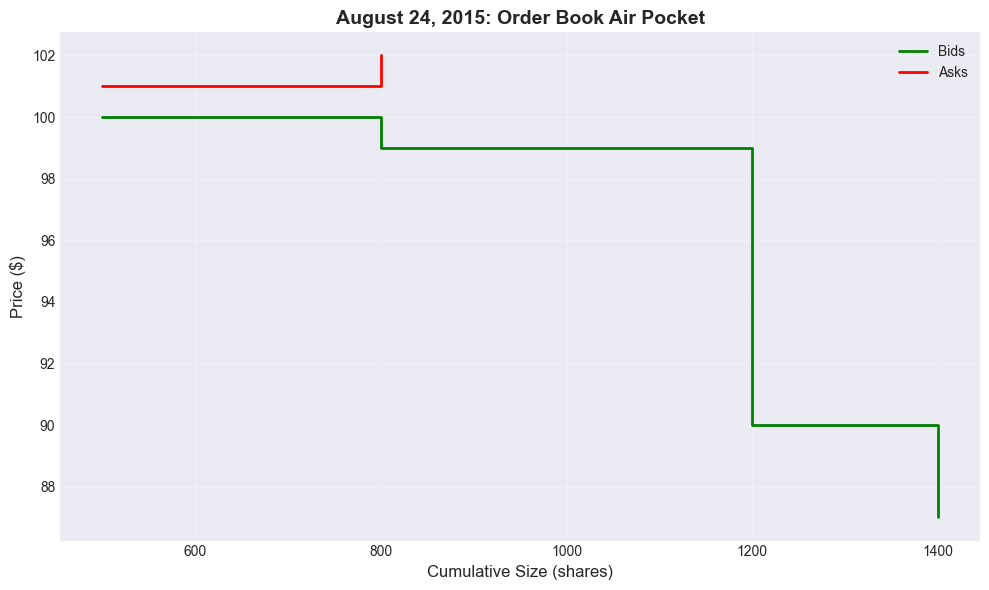

In [8]:
# Recreate for visualization
crisis_book_viz = OrderBook()
crisis_book_viz.add_bid(100.00, 500)
crisis_book_viz.add_bid(99.00, 300)
crisis_book_viz.add_bid(90.00, 400)
crisis_book_viz.add_bid(87.00, 200)
crisis_book_viz.add_ask(101.00, 500)
crisis_book_viz.add_ask(102.00, 300)

bids = [(b.price, b.size) for b in crisis_book_viz.bids]
asks = [(a.price, a.size) for a in crisis_book_viz.asks]

fig = plot_order_book(bids, asks, "August 24, 2015: Order Book Air Pocket")
plt.show()

## Part 4: Real Data - RSP Crash and Recovery

Let's examine actual price data from August 24, 2015.

In [9]:
# Check if setup was run
try:
    DATA_PATH_PREFIX
except NameError:
    raise RuntimeError(
        "⚠️ Setup cell not run! Please run Cell 1 first.\n"
        "In Colab: Runtime → Run all\n"
        "Locally: Run cells from top to bottom"
    )

# Load sample data
df = pd.read_csv(f'{DATA_PATH_PREFIX}aug24_price_data.csv', parse_dates=['timestamp'])

# Filter to RSP
rsp = df[df['ticker'] == 'RSP'].copy()

# Validate data exists
if len(rsp) == 0:
    raise ValueError("No RSP data found in dataset. Check CSV file.")

# Handle halts (convert to NaN for plotting)
rsp.loc[rsp['price'] == 'HALTED', 'price'] = np.nan
rsp['price'] = pd.to_numeric(rsp['price'])

# Filter to valid prices for statistics
rsp_valid = rsp[rsp['price'].notna()].copy()

# Display key statistics
print("RSP (Guggenheim S&P 500 Equal Weight ETF)")
print("="*50)
print(f"Previous close: $76.15")
print(f"Low: ${rsp_valid['price'].min():.2f}")
print(f"Decline: {(rsp_valid['price'].min() - 76.15) / 76.15 * 100:.1f}%")
print(f"\niNAV (fairly stable): ${rsp['inav'].iloc[0]:.2f}")
print(f"\nMaximum discount to iNAV:")
max_discount_idx = (rsp_valid['price'] - rsp_valid['inav']).idxmin()
max_discount_price = rsp_valid.loc[max_discount_idx, 'price']
max_discount_inav = rsp_valid.loc[max_discount_idx, 'inav']
print(f"  ${max_discount_price:.2f} vs ${max_discount_inav:.2f}")
print(f"  Discount: {(max_discount_price - max_discount_inav) / max_discount_inav * 100:.1f}%")
print(f"\n⚠️ S&P 500 underlying index: Only down ~4%")
print(f"💡 ETF structure broke down completely")

RSP (Guggenheim S&P 500 Equal Weight ETF)
Previous close: $76.15
Low: $43.77
Decline: -42.5%

iNAV (fairly stable): $71.23

Maximum discount to iNAV:
  $43.77 vs $71.23
  Discount: -38.6%

⚠️ S&P 500 underlying index: Only down ~4%
💡 ETF structure broke down completely


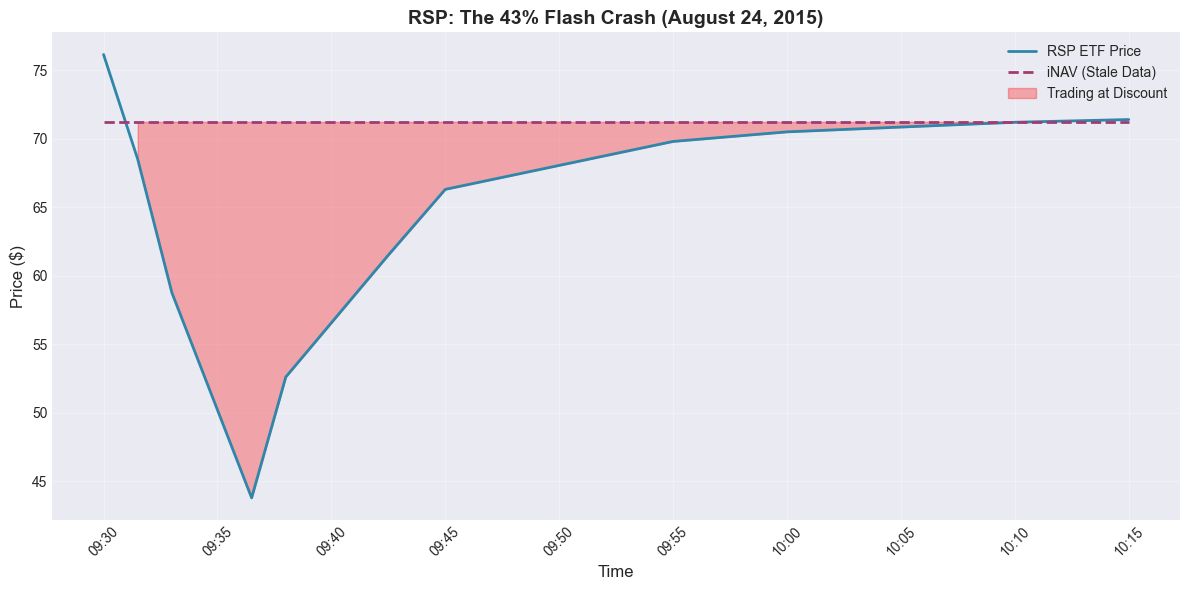

In [10]:
# Visualize RSP crash
rsp_clean = rsp[rsp['price'].notna()].copy()

fig = plot_price_vs_inav(
    timestamps=rsp_clean['timestamp'].tolist(),
    etf_prices=rsp_clean['price'].tolist(),
    inav_values=rsp_clean['inav'].tolist(),
    title="RSP: The 43% Flash Crash (August 24, 2015)",
    etf_label="RSP ETF Price",
    inav_label="iNAV (Stale Data)"
)
plt.show()

## Part 5: Stop-Loss Cascade

Retail investors with stop-loss orders experienced severe slippage.
Let's model the IUSV example from the guide.

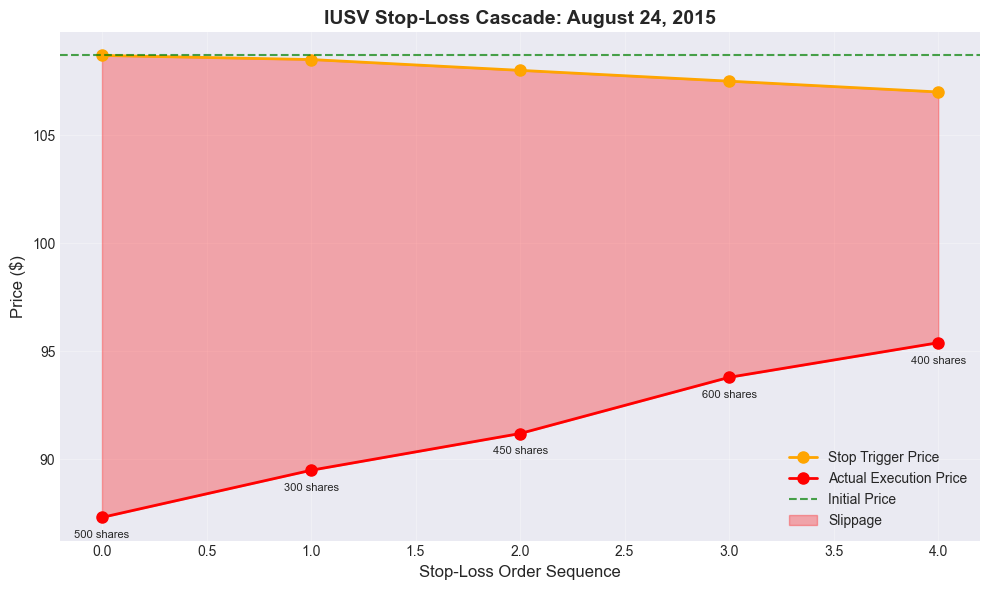


Retail Investor Impact Analysis

Order 1: 500 shares
  Stop trigger: $108.69 (expected 0.0% loss)
  Executed at: $87.32 (actual 19.7% loss)
  Excess loss: 19.7% ($10,685.00)

Order 2: 300 shares
  Stop trigger: $108.50 (expected 0.2% loss)
  Executed at: $89.50 (actual 17.7% loss)
  Excess loss: 17.5% ($5,700.00)

Order 3: 450 shares
  Stop trigger: $108.00 (expected 0.6% loss)
  Executed at: $91.20 (actual 16.1% loss)
  Excess loss: 15.5% ($7,560.00)

Order 4: 600 shares
  Stop trigger: $107.50 (expected 1.1% loss)
  Executed at: $93.80 (actual 13.7% loss)
  Excess loss: 12.6% ($8,220.00)

Order 5: 400 shares
  Stop trigger: $107.00 (expected 1.6% loss)
  Executed at: $95.40 (actual 12.2% loss)
  Excess loss: 10.7% ($4,640.00)


In [11]:
# IUSV (iShares Core S&P U.S. Value ETF) scenario
stop_triggers = [108.69, 108.50, 108.00, 107.50, 107.00]
execution_prices = [87.32, 89.50, 91.20, 93.80, 95.40]
sizes = [500, 300, 450, 600, 400]
initial_price = 108.69

fig = plot_stop_loss_cascade(
    stop_triggers=stop_triggers,
    execution_prices=execution_prices,
    sizes=sizes,
    initial_price=initial_price,
    title="IUSV Stop-Loss Cascade: August 24, 2015"
)
plt.show()

# Calculate losses
print("\nRetail Investor Impact Analysis")
print("="*50)
for i in range(len(stop_triggers)):
    trigger = stop_triggers[i]
    execution = execution_prices[i]
    size = sizes[i]
    
    expected_loss = (108.69 - trigger) / 108.69 * 100
    actual_loss = (108.69 - execution) / 108.69 * 100
    excess_loss = actual_loss - expected_loss
    dollar_loss = (trigger - execution) * size
    
    print(f"\nOrder {i+1}: {size} shares")
    print(f"  Stop trigger: ${trigger:.2f} (expected {expected_loss:.1f}% loss)")
    print(f"  Executed at: ${execution:.2f} (actual {actual_loss:.1f}% loss)")
    print(f"  Excess loss: {excess_loss:.1f}% (${dollar_loss:,.2f})")

## Part 6: LULD Circuit Breakers

LULD (Limit Up-Limit Down) circuit breakers were supposed to prevent this.
Let's see what happened.

In [12]:
# Load halt data
halts_df = pd.read_csv(f'{DATA_PATH_PREFIX}luld_halts.csv', parse_dates=['halt_start', 'halt_end'])

# RSP halts only
rsp_halts = halts_df[halts_df['ticker'] == 'RSP'].copy()

# Validate data exists
if len(rsp_halts) == 0:
    print("⚠️ No RSP halt data found in dataset.")
    print("This may indicate the data file needs updating or RSP had no halts.")
else:
    print("RSP LULD Halts on August 24, 2015")
    print("="*50)
    print(f"Total halts: {len(rsp_halts)}\n")
    
    total_halt_time = 0
    for idx, row in rsp_halts.iterrows():
        duration = row['duration_sec']
        total_halt_time += duration
        print(f"Halt #{int(row['halt_number'])}:")
        print(f"  Time: {row['halt_start'].strftime('%H:%M:%S')} - {row['halt_end'].strftime('%H:%M:%S')}")
        print(f"  Price before: ${row['price_before']:.2f}")
        print(f"  Price after: ${row['price_after']:.2f}")
        print(f"  Change during halt: {(row['price_after'] - row['price_before']) / row['price_before'] * 100:+.1f}%\n")
    
    print(f"Total halt time: {total_halt_time} seconds ({total_halt_time / 60:.1f} minutes)")
    print(f"\n💡 Between 9:30 AM - 10:30 AM (60 minutes):")
    print(f"   Halted: {total_halt_time / 60:.1f} minutes")
    print(f"   Trading: {60 - total_halt_time / 60:.1f} minutes")
    print(f"\n⚠️ Only {(60 - total_halt_time / 60) / 60 * 100:.0f}% of the time was available for trading")

RSP LULD Halts on August 24, 2015
Total halts: 10

Halt #1:
  Time: 09:33:45 - 09:38:45
  Price before: $58.75
  Price after: $52.60
  Change during halt: -10.5%

Halt #2:
  Time: 09:39:20 - 09:44:20
  Price before: $46.30
  Price after: $61.50
  Change during halt: +32.8%

Halt #3:
  Time: 09:45:30 - 09:50:30
  Price before: $68.90
  Price after: $66.30
  Change during halt: -3.8%

Halt #4:
  Time: 09:51:15 - 09:56:15
  Price before: $64.20
  Price after: $69.80
  Change during halt: +8.7%

Halt #5:
  Time: 09:57:00 - 10:02:00
  Price before: $67.50
  Price after: $70.50
  Change during halt: +4.4%

Halt #6:
  Time: 10:03:20 - 10:08:20
  Price before: $69.20
  Price after: $70.50
  Change during halt: +1.9%

Halt #7:
  Time: 10:09:45 - 10:14:45
  Price before: $70.80
  Price after: $71.20
  Change during halt: +0.6%

Halt #8:
  Time: 10:16:00 - 10:21:00
  Price before: $71.10
  Price after: $71.40
  Change during halt: +0.4%

Halt #9:
  Time: 10:22:30 - 10:27:30
  Price before: $71.30

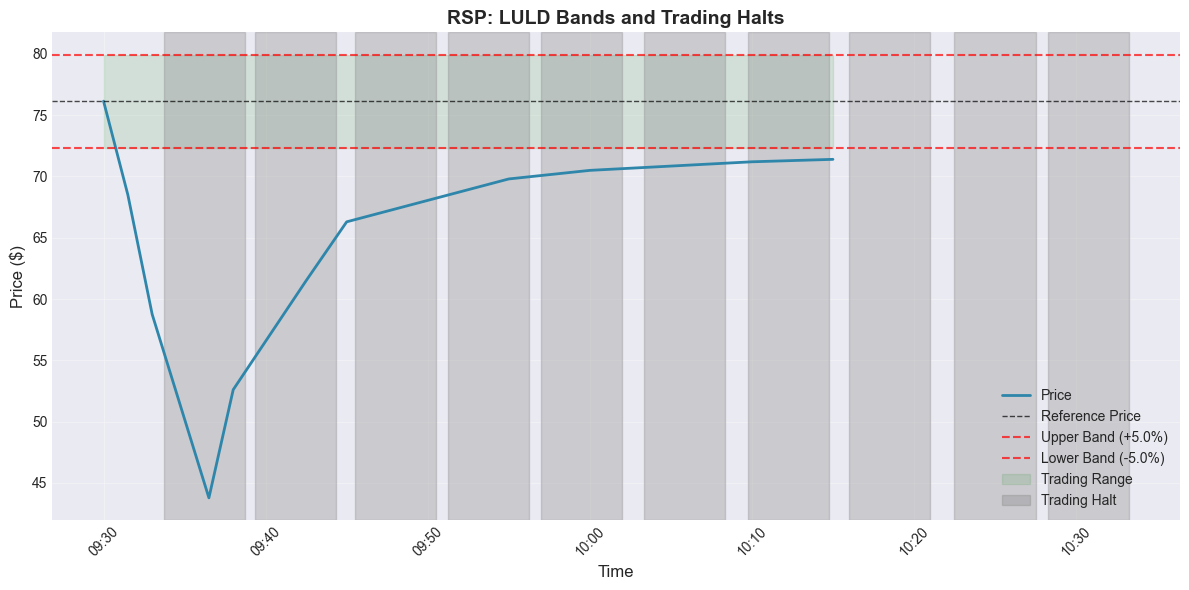

In [13]:
# Visualize LULD bands for RSP
rsp_clean = rsp[rsp['price'].notna()].copy()

# Convert halt times to proper format for visualization
halt_periods = [(row['halt_start'], row['halt_end']) 
                for idx, row in rsp_halts.iterrows()]

fig = plot_luld_bands(
    timestamps=rsp_clean['timestamp'].tolist(),
    prices=rsp_clean['price'].tolist(),
    reference_price=76.15,
    band_width_pct=5.0,
    halts=halt_periods,
    title="RSP: LULD Bands and Trading Halts"
)
plt.show()

### LULD Band Calculator

Now let's use the LULD calculator to understand exactly how the bands worked during the flash crash.

The calculator implements the precise SEC/FINRA regulatory methodology:
- **Band percentages** vary by security tier and price level
- **Time-of-day adjustments**: Bands are DOUBLED during opening (9:30-9:45 AM) and closing (3:35-4:00 PM) periods
- **Leveraged ETPs**: Bands are multiplied by leverage factor

Let's analyze DVY (iShares Select Dividend ETF) at 9:35 AM on August 24, 2015:

In [14]:
# Import LULD calculator
from luld_calculator import analyze_flash_crash_halt

# DVY at 9:35 AM on August 24, 2015
result = analyze_flash_crash_halt(
    ticker='DVY',
    reference_price=75.50,  # iNAV before crash
    actual_price=65.20,     # Price that triggered first halt
    tier=1,                 # Tier 1 security (large ETF)
    timestamp=datetime(2015, 8, 24, 9, 35, 0)
)

print("DVY LULD BAND ANALYSIS")
print("="*60)
print(f"Ticker: {result['ticker']}")
print(f"Timestamp: {result['timestamp']}")
print(f"Time Category: {result['time_category'].upper()} (9:30-9:45 AM)")
print(f"\nReference Price: ${result['reference_price']:.2f}")
print(f"Actual Price: ${result['actual_price']:.2f}")
print(f"\nLULD Band Percentage: {result['band_percentage']:.1f}% (DOUBLED from 5% base)")
print(f"Lower Band: ${result['lower_band']:.2f}")
print(f"Upper Band: ${result['upper_band']:.2f}")
print(f"\nPrice Change: ${result['price_change']:.2f} ({result['price_change_pct']:.1f}%)")
print(f"Distance from Band: ${result['distance_from_band']:.2f}")
print(f"\n{'⚠️ HALT TRIGGERED' if result['halt_triggered'] else '✅ Within Bands'}")

if result['halt_triggered']:
    print(f"\nAnalysis:")
    print(f"  - DVY fell {abs(result['price_change_pct']):.1f}% from reference price")
    print(f"  - Lower band was at ${result['lower_band']:.2f} (10% below reference)")
    print(f"  - Actual price ${result['actual_price']:.2f} breached band by ${abs(result['distance_from_band']):.2f}")
    print(f"  - This triggered a 5-minute trading halt")
    print(f"\n💡 Key Insight:")
    print(f"  Opening period bands are DOUBLED (10% vs 5% normal)")
    print(f"  DVY had to fall MORE than 10% to trigger halt")
    print(f"  This timing amplified the crash severity")

DVY LULD BAND ANALYSIS
Ticker: DVY
Timestamp: 2015-08-24 09:35:00
Time Category: OPENING (9:30-9:45 AM)

Reference Price: $75.50
Actual Price: $65.20

LULD Band Percentage: 10.0% (DOUBLED from 5% base)
Lower Band: $67.95
Upper Band: $83.05

Price Change: $-10.30 (-13.6%)
Distance from Band: $-2.75

⚠️ HALT TRIGGERED

Analysis:
  - DVY fell 13.6% from reference price
  - Lower band was at $67.95 (10% below reference)
  - Actual price $65.20 breached band by $2.75
  - This triggered a 5-minute trading halt

💡 Key Insight:
  Opening period bands are DOUBLED (10% vs 5% normal)
  DVY had to fall MORE than 10% to trigger halt
  This timing amplified the crash severity


## Summary: What We Learned

### 1. ETF Pricing Breakdown
- **Normal**: ETF price ≈ iNAV (arbitrage works)
- **August 24**: iNAV based on stale/halted stock prices
- **Result**: Arbitrage impossible → market makers stepped away

### 2. Order Book Air Pockets
- **Normal**: Dense liquidity, tight spreads (5-10 bps)
- **August 24**: Sparse liquidity, wide spreads (2,000+ bps)
- **Result**: Market orders fell through gaps

### 3. Stop-Loss Orders = Market Orders
- **Stop-loss**: Triggers at $99, executes at $87 (12% worse)
- **No price protection** once triggered
- **Lesson**: Use stop-limit orders instead

### 4. LULD Circuit Breakers
- **Intended**: Pause trading, allow price discovery
- **Actual**: 10 halts in 1 hour, only 2 minutes of trading
- **Problem**: Can't hedge during halts, uncertainty increased

---

## Next Steps

- Read the guide files in `guide/` for detailed explanations
- Explore other notebooks for deeper dives
- Examine the source code in `src/` to understand the calculations
- Review the SVG diagrams in `assets/charts/`

**Key Takeaway**: Size doesn't protect you. Market structure can break. Use limit orders.